In [2]:
!pip install persiantools

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import missingno as msno 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from persiantools.jdatetime import JalaliDate
from persiantools.jdatetime import JalaliDateTime
import datetime, pytz
import math

# 0 Reading the Data

In [4]:
df = pd.read_excel('/content/drive/MyDrive/projects/maintenance/output_en.xlsx').drop('BN',axis=1)

## 0.1 Convert Date Time to Gregorian

In [5]:
datecols = ['CFB','DFB','PS']
df[datecols] = df[datecols].applymap(lambda x: 
                                     JalaliDate(int(x[:4]),
                                                    int(x[5:7]),
                                                    int(x[8:10])).to_gregorian() if isinstance(x,str) else None)

## 0.2 Data Head

In [ ]:
df.head(5)

,TOF,AF,DS,feeder,RC,TOP,Relay,COB,PD,COP,DFB,CFB,DOFDB,PS,STOLP,EENS
0,A,A,A,A,0.177419,A,A,A,NaN,NaN,2019-03-21,2019-03-21,5,None,NaN,0.010946
1,A,B,B,B,0.145161,A,A,B,B,B,2019-03-21,2019-03-21,2,None,NaN,0.003127
2,A,A,C,C,0.032258,A,A,C,NaN,NaN,2019-03-21,2019-03-21,42,None,NaN,0.016419
3,A,A,A,D,0.048387,A,A,D,C,C,2019-03-22,2019-03-22,65,2019-03-22,415.0,0.039093
4,A,C,D,A,0.161290,A,B,E,D,D,2019-03-22,2019-03-22,24,2019-03-22,334.0,0.075059


## 0.2 Fill NaT Items

In [6]:
nats = df.CFB.isnull()
df.CFB[nats] = df.DFB[nats]
df.loc[nats,].head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,TOF,AF,DS,feeder,RC,TOP,Relay,COB,PD,COP,DFB,CFB,DOFDB,PS,STOLP,EENS
944,A,E,G,C,0.225806,A,F,S,M,EE,2019-09-25,2019-09-25,0,2019-09-25,16.0,0.043002
974,A,D,Y,H,0.193548,A,A,D,E,C,2019-10-04,2019-10-04,0,2019-10-04,100.0,0.061767
1628,A,D,GG,C,0.064516,A,A,D,C,C,2020-03-17,2020-03-17,0,2020-03-17,16.0,0.012510


In [53]:
df['Count'] = 1
af_dfb = {}
for AF in df.AF.unique():
    af_dfb[AF] = df.loc[df.AF == AF,['DFB','DOFDB','STOLP','EENS','Count']].groupby('DFB',as_index=False).sum()
    af_dfb[AF].set_index(pd.to_datetime(af_dfb[AF].DFB), inplace=True)
    af_dfb[AF] = af_dfb[AF].resample('D').sum().fillna(0)
    af_dfb[AF].reset_index(inplace=True)

In [54]:
af_dfb['A'].head(5)

,DFB,DOFDB,STOLP,EENS,Count
0,2019-03-21,47,0.0,0.027365,2
1,2019-03-22,65,415.0,0.039093,1
2,2019-03-23,19,0.0,0.000000,1
3,2019-03-24,0,0.0,0.000000,0
4,2019-03-25,5,0.0,0.001564,1


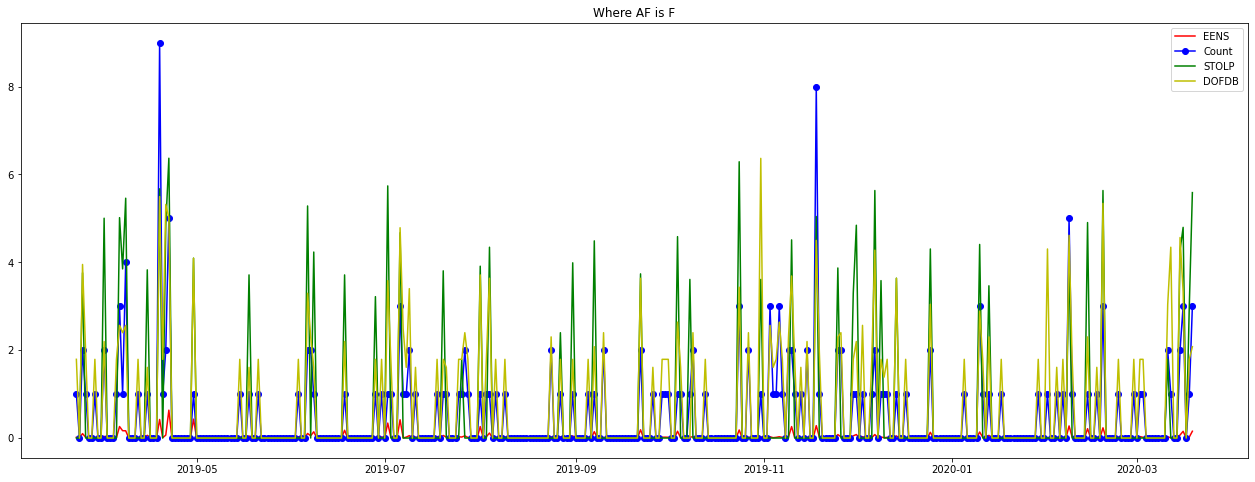

In [57]:
plt.figure(figsize=(22,8))
label = 'B'
plt.plot(af_dfb[label].DFB,af_dfb[label].EENS,c='r',label='EENS')
plt.plot(af_dfb[label].DFB,af_dfb[label].Count,c='b',label='Count',marker='o')
plt.plot(af_dfb[label].DFB,np.log(af_dfb[label].STOLP+1),c='g',label='STOLP') # the differnce is huge
plt.plot(af_dfb[label].DFB,np.log(af_dfb[label].DOFDB+1),c='y',label='DOFDB') # the differnce is huge
plt.title(f'Where AF is {label}')
plt.legend()
plt.show()

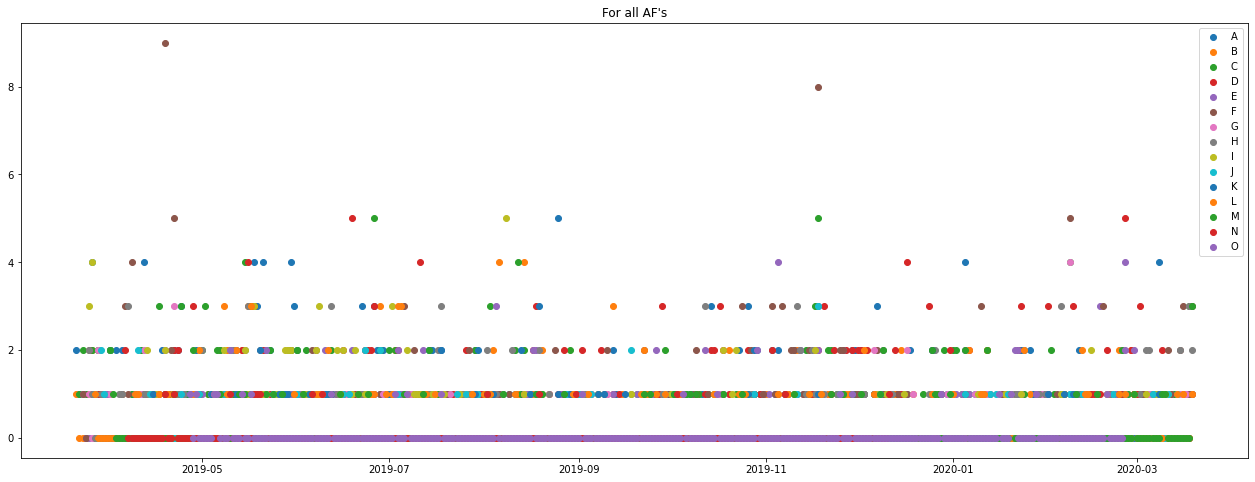

In [64]:
plt.figure(figsize=(22,8))
for k,v in af_dfb.items():
    plt.plot(v.DFB,v.Count,label=k)
plt.title('For all AF\'s')
plt.legend()
plt.show()

In [75]:
sorted([(key,item.Count.mean()) for
        key,item in af_dfb.items()],
       key=lambda x:x[1],
       reverse=True)

[('D', 0.6363636363636364),
 ('A', 0.5494505494505495),
 ('C', 0.5384615384615384),
 ('F', 0.4903581267217631),
 ('H', 0.37119113573407203),
 ('I', 0.32011331444759206),
 ('E', 0.27900552486187846),
 ('B', 0.27624309392265195),
 ('L', 0.2562674094707521),
 ('M', 0.2062146892655367),
 ('K', 0.19540229885057472),
 ('J', 0.16666666666666666),
 ('G', 0.1532033426183844),
 ('O', 0.10784313725490197),
 ('N', 0.064)]

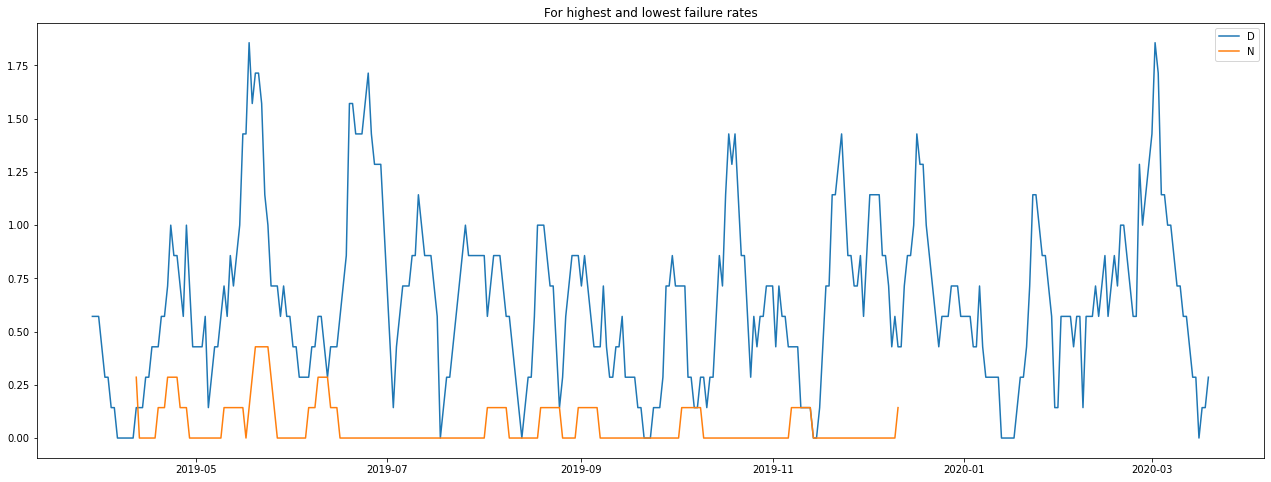

In [87]:
plt.figure(figsize=(22,8))
w = 7
for lab in ['D','N']:
    plt.plot(af_dfb[lab].DFB[w-1:],np.convolve(af_dfb[lab].Count, np.ones(w), 'valid') / w,label=lab)
plt.title('For highest and lowest failure rates')
plt.legend()
plt.show()